In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import joblib

%matplotlib inline

# 데이터 전처리

In [2]:
cl15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/CL15_fix.csv")
cl10 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/CL10_fix.csv")
gm15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/GM15_fix.csv")
gm10 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/GM10_fix.csv")


In [4]:
print(np.sum(cl15["blueWins"])/len(cl15))
print(np.sum(cl10["blueWins"])/len(cl10))
print(np.sum(gm15["blueWins"])/len(gm15))
print(np.sum(gm10["blueWins"])/len(gm10))

0.45627876397107164
0.45627876397107164
0.4718162839248434
0.47190426638917793


In [8]:
new_cl15 = pd.DataFrame()

In [9]:
new_cl15 = pd.concat([cl15[cl15["blueWins"]==0].sample(frac=0.84), cl15[cl15["blueWins"]==1]])

In [10]:
new_cl15

,blueWins,blueTotalGolds,blueTotalLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueTotalDamageToChampion,blueFirstBlood,blueKill,blueDeath,blueAssist,...,blueAIR_DRAGON,blueEARTH_DRAGON,blueCHEMTECH_DRAGON,blueHEXTECH_DRAGON,redWATER_DRAGON,redFIRE_DRAGON,redAIR_DRAGON,redEARTH_DRAGON,redCHEMTECH_DRAGON,redHEXTECH_DRAGON
1264,0,25312,45,389,60,25765,1,9,13,7,...,0,0,0,0,0,1,0,0,0,0
480,0,28215,43,354,72,28554,1,15,12,20,...,0,0,0,0,0,0,0,1,0,0
1397,0,25262,42,322,64,26362,0,10,12,16,...,0,0,0,0,1,0,0,0,0,1
565,0,26213,47,370,68,33432,1,13,18,11,...,0,0,0,0,0,0,0,0,1,0
525,0,23939,42,310,77,30846,0,7,17,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,1,26445,45,347,70,23012,1,11,7,16,...,0,0,1,0,0,0,0,0,0,1
1515,1,25085,45,377,70,26942,0,9,11,8,...,1,0,0,0,0,0,0,0,0,0
1516,1,30554,47,396,102,29471,1,14,10,12,...,0,0,0,1,1,0,0,0,0,0
1518,1,31522,45,340,60,38168,1,21,9,31,...,0,0,1,0,0,0,0,0,0,1


In [12]:
def train_test(df):
  x_train = df.drop(['blueWins', 'matchMin'], axis=1)
  y_train = df['blueWins']
  return x_train, y_train

In [13]:
x_train, y_train = train_test(new_cl15)

val_size = 0.2

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

## LGBM 모델 적용

In [14]:
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree

In [15]:
model = LGBMClassifier()
model.fit(x_train, y_train)
valid_pred = model.predict(x_valid)
accuracy = accuracy_score(y_valid, valid_pred)
print("Accuracy: ", accuracy*100)

Accuracy:  74.10071942446042


# 베이지안 optimization

In [18]:
from bayes_opt import BayesianOptimization

In [19]:
# 탐색 대상 함수 (XGBRegressor)
def LGBM_cv(max_depth,learning_rate, n_estimators,
            min_child_weight, subsample
            ,colsample_bytree, silent=True):

    # 모델 정의
    model = LGBMClassifier(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree
                            )
    # 모델 훈련
    model.fit(x_train, y_train)

    # 예측값 출력
    y_pred= model.predict(x_valid)

    return f1_score(y_valid, y_pred)

In [20]:
pbounds = {'max_depth': (3, 10),
                'learning_rate': (0.01, 0.3),
                'n_estimators': (20,100),
                'min_child_weight': (0, 3),
                'subsample': (0.5, 1),
                'colsample_bytree' :(0.2, 1)
                }

lm_bo=BayesianOptimization(f=LGBM_cv, pbounds=pbounds, verbose=2, random_state=1 )    

lm_bo.maximize(init_points=2, n_iter=100)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7655    | 0.5336    | 0.2189    | 3.001     | 0.907     | 31.74     | 0.5462    |
| 2         | 0.7881    | 0.349     | 0.1102    | 5.777     | 1.616     | 53.54     | 0.8426    |
| 3         | 0.7593    | 0.5736    | 0.2719    | 6.849     | 2.075     | 53.05     | 0.646     |
| 4         | 0.7782    | 0.6782    | 0.1023    | 7.641     | 1.345     | 33.78     | 0.6515    |
| 5         | 0.7526    | 0.4603    | 0.2457    | 6.101     | 1.633     | 53.27     | 0.9138    |
| 6         | 0.7619    | 0.5276    | 0.04547   | 8.11      | 2.604     | 73.03     | 0.6975    |
| 7         | 0.7542    | 0.9334    | 0.03744   | 9.907     | 2.841     | 21.07     | 0.727     |
| 8         | 0.7677    | 0.7552    | 0.1763    | 5.304     | 2.129     | 83.79     | 0.5152    |
| 9         | 0.7661

In [22]:
print(lm_bo.max['params'])

{'colsample_bytree': 0.21392451718552563, 'learning_rate': 0.10607337279022755, 'max_depth': 6.260548661935738, 'min_child_weight': 0.8612770647007086, 'n_estimators': 70.94945812283854, 'subsample': 0.6986680113586496}


In [23]:
param = {'colsample_bytree': 0.21392451718552563, 'learning_rate': 0.10607337279022755, 'max_depth': 6, 
         'min_child_weight': 0.8612770647007086, 'n_estimators':71, 'subsample': 0.6986680113586496}
model = LGBMClassifier(**param)
model.fit(x_train, y_train)
valid_pred = model.predict(x_valid)
accuracy = accuracy_score(y_valid, valid_pred)
print("Accuracy: ", accuracy*100)

Accuracy:  78.05755395683454


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

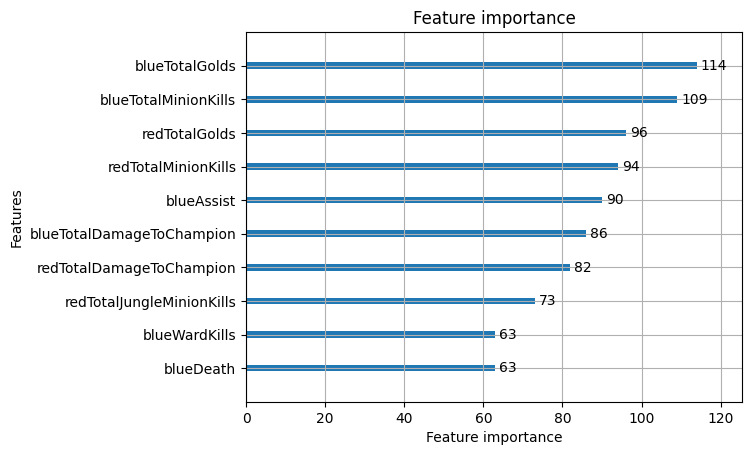

In [28]:
plot_importance(model, max_num_features=10)

DATA 불러오기

In [15]:
br15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/BR15_fix.csv")
di15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/DI15_fix.csv")
gl15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/GL15_fix.csv")
ir15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/IR15_fix.csv")
pl15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/PL15_fix.csv")
si15 = pd.read_csv("/Users/ichang-ug/Documents/GitHub/esports_YSAL/LOL/Data/SI15_fix.csv")

data15 = [ir15, br15, si15, gl15, pl15 ,di15]
data_label = ["ir15", "br15","si15", "gl15", "pl15" ,"di15"]

In [17]:
for i,data in enumerate(data15):
    x_train = data.drop(["matchMin","blueWins"], axis=1)
    y_train = data["blueWins"]
    y_pred = model.predict(x_train)
    accuracy = accuracy_score(y_train, y_pred)
    print(data_label[i])
    print("Accuracy: ", accuracy*100)

ir15
Accuracy:  59.5
br15
Accuracy:  52.736318407960205
si15
Accuracy:  60.29411764705882
gl15
Accuracy:  51.243781094527364
pl15
Accuracy:  68.96551724137932
di15
Accuracy:  77.83251231527095
